# Demo for Hybrid Payoff Bandits

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from algorithms import HyLinUCB, DisLinUCB, LinUCBClassic, HyLinUCBv2
from environment import HybridBandits

In [2]:
def probe_algo(env: HybridBandits, algo_arr, nrows, ncols):
    theta_dict = {}
    beta_dict = {}
    algo_dict = {}
    for algo in algo_arr:
        if algo.name.startswith('LinUCBClassic'):
            theta_dict['LinUCBClassic'] = algo.theta_hat
            beta_dict['LinUCBClassic'] = algo.beta_hat_arr
            algo_dict['LinUCBClassic'] = algo
        elif algo.name.startswith('DisLinUCB'):
            theta_dict['DisLinUCB'] = algo.theta_hat_arr
            algo_dict['DisLinUCB'] = algo
        elif algo.name.startswith('HyLinUCB'):
            theta_dict['HyLinUCB'] = algo.theta_hat
            beta_dict['HyLinUCB'] = algo.beta_hat_arr
            algo_dict['HyLinUCB'] = algo
    #print('Theta:', theta_dict)
    #print('Beta:', beta_dict)
    if ncols <= 1:
        fig, ax = plt.subplots(nrows, sharex=False, sharey=False, figsize=(30, 30))
        x = 0
        base = [str(i) for i in np.arange(1, env.L + 1)]
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            reward_arr = np.zeros((env.L, len(algo_arr)+1))
            reward_bonuses = np.zeros((env.L, len(algo_arr)+1))
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr[j, 0] = np.dot(theta, a) + np.dot(beta_arr[j], b)
                for k, keyname in enumerate(algo_dict.keys()):
                    if keyname == 'DisLinUCB':
                        reward_arr[j, k+1] = np.dot(theta_dict['DisLinUCB'][j], np.concatenate((a,b)))
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=np.concatenate((a,b))) - reward_arr[j, k+1]
                    else:
                        reward_arr[j, k+1] = np.dot(theta_dict[keyname], a) + np.dot(beta_dict[keyname][j], b)
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=(a,b)) - reward_arr[j, k+1]
            columns = ['True'] + [k for k in algo_dict.keys()]
            df = pd.DataFrame(reward_arr, columns=columns, index=base)
            df.plot.bar(yerr=reward_bonuses.T, capsize=2, rot=0, width=0.8, ax=ax[x])
            ax[x].legend().set_visible(False)
            ax[x].set_title(f'Context:{i}')
            ax[x].grid()
            x += 1
        handles, labels = ax[-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
        plt.show()
    else:
        fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(30, 30))
        x, y = 0, 0
        base = [str(i) for i in np.arange(1, env.L + 1)]
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            if x == nrows:
                x = 0
                y += 1
            reward_arr = np.zeros((env.L, len(algo_arr)+1))
            reward_bonuses = np.zeros((env.L, len(algo_arr)+1))
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr[j, 0] = np.dot(theta, a) + np.dot(beta_arr[j], b)
                for k, keyname in enumerate(algo_dict.keys()):
                    if keyname == 'DisLinUCB':
                        reward_arr[j, k+1] = np.dot(theta_dict['DisLinUCB'][j], np.concatenate((a,b)))
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=np.concatenate((a,b))) - reward_arr[j, k+1]
                    else:
                        reward_arr[j, k+1] = np.dot(theta_dict[keyname], a) + np.dot(beta_dict[keyname][j], b)
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=(a,b)) - reward_arr[j, k+1]
            columns = ['True'] + [k for k in algo_dict.keys()]
            df = pd.DataFrame(reward_arr, columns=columns, index=base)
            df.plot.bar(yerr=reward_bonuses.T, capsize=2, rot=0, width=0.8, ax=ax[x][y])
            ax[x][y].legend().set_visible(False)
            ax[x][y].set_title(f'Context:{i}')
            ax[x][y].grid()
            x += 1
        handles, labels = ax[-1][-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
        plt.show()

In [3]:
def plot_action_freq(ls, env, nrows, ncols):
        if ncols <= 1:
            fig, ax = plt.subplots(nrows, sharex=False, sharey=False, figsize=(30, 30))
            x = 0
            base = [str(i) for i in np.arange(1, env.L + 1)]
            for i in range(env.num_context):
                act_freq_dict = ls[i]
                data = {}
                base_copy = [b for b in base]
                for k in act_freq_dict.keys():
                    data[k] = []
                    for a in range(env.L):
                        freq = np.sum(np.array(act_freq_dict[k]) == a)
                        if a == env.best_arm[i] and not(base_copy[a].endswith('*')):
                            base_copy[a] += '*'
                        data[k].append(freq)
                df = pd.DataFrame(data, index=base_copy)
                df.plot.bar(rot=0, width=0.8, ax=ax[x])
                ax[x].legend().set_visible(False)
                ax[x].set_title(f'Context:{i}')
                ax[x].grid()
                x += 1
            handles, labels = ax[-1].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
            plt.show()
        else:
            fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(30, 30))
            x, y = 0, 0
            base = [str(i) for i in np.arange(1, env.L + 1)]
            for i in range(env.num_context):
                if x == nrows:
                    x = 0
                    y += 1
                act_freq_dict = ls[i]
                data = {}
                base_copy = [b for b in base]
                for k in act_freq_dict.keys():
                    data[k] = []
                    for a in range(env.L):
                        freq = np.sum(np.array(act_freq_dict[k]) == a)
                        if a == env.best_arm[i]:
                            base_copy[a] += '*'
                        data[k].append(freq)
                df = pd.DataFrame(data, index=base_copy)
                df.plot.bar(rot=0, width=0.8, ax=ax[x][y])
                ax[x][y].legend().set_visible(False)
                ax[x][y].set_title(f'Context:{i}')
                ax[x][y].grid()
                x += 1
            handles, labels = ax[-1][-1].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
            plt.show()

In [4]:
# Function to run 1 trial
def simulate(env, algo_arr, T, display=None):
    d = {}
    for algo in algo_arr:
        if algo.name.startswith('LinUCBClassic'):
            d['LinUCBClassic'] = []
        elif algo.name.startswith('DisLinUCB'):
            d['DisLinUCB'] = []
        elif algo.name.startswith('HyLinUCB'):
            d['HyLinUCB'] = []
    con_act_ls = [deepcopy(d) for _ in range(env.num_context)]
    for t in tqdm(range(T)):
        a_t = []
        context_id = env.context_seq[env.t]
        for algo in algo_arr:
            a = algo.next_action()
            if algo.name.startswith('LinUCBClassic'):
                con_act_ls[context_id]['LinUCBClassic'].append(a)
            elif algo.name.startswith('DisLinUCB'):
                con_act_ls[context_id]['DisLinUCB'].append(a)
            elif algo.name.startswith('HyLinUCB'):
                con_act_ls[context_id]['HyLinUCB'].append(a)
            a_t.append(a)
        rewards_t, regrets_t, action_set_t = env.step(a_t)
        for i, algo in enumerate(algo_arr):
            algo.update(rewards_t[i], regrets_t[i], action_set_t)
        if display is not None:
            if ((t+1) % display) == 0:
                nr = 5
                print('Timestep:', (t+1))
                probe_algo(env, algo_arr, nrows=nr, ncols=env.num_context // nr)
    plot_action_freq(con_act_ls, env, nrows=nr, ncols=env.num_context // nr)
    return con_act_ls

In [5]:
def create_reward_plot(env:HybridBandits, nrows, ncols):
    if nrows <= 1:
        fig, ax = plt.subplots(ncols, sharex=True, sharey=True)
        x = 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            reward_arr = []
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr.append(np.dot(theta, a) + np.dot(beta_arr[j], b))
            ax[x].bar(base, reward_arr)
            ax[x].grid()
            x += 1
        plt.show()
    else:
        fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
        x, y = 0, 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            x = x % nrows
            y = y % ncols
            reward_arr = []
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr.append(np.dot(theta, a) + np.dot(beta_arr[j], b))
            ax[x][y].bar(base, reward_arr)
            ax[x][y].grid()
            x += 1
            y += 1
        plt.show()
    

In [6]:
def plot_regret(result_dict, T):
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    x = np.arange(1, T+1)
    for k in result_dict.keys():
        ax[0][0].plot(x, result_dict[k]['mean_reward'], label=k)
        min_reward = np.array(result_dict[k]['mean_reward']) - np.array(result_dict[k]['std_reward'])
        max_reward = np.array(result_dict[k]['mean_reward']) + np.array(result_dict[k]['std_reward'])
        ax[0][0].fill_between(x, min_reward, max_reward, alpha=0.2)

        ax[0][1].plot(x, result_dict[k]['mean_regret'], label=k)
        min_regret = np.array(result_dict[k]['mean_regret']) - np.array(result_dict[k]['std_regret'])
        max_regret = np.array(result_dict[k]['mean_regret']) + np.array(result_dict[k]['std_regret'])
        ax[0][1].fill_between(x, min_regret, max_regret, alpha=0.2)

        ax[1][0].plot(x, result_dict[k]['time_avg_reward'], label=k)
        ax[1][1].plot(x, result_dict[k]['time_avg_regret'], label=k)

    for i in range(2):
        for j in range(2):
            ax[i][j].set_xlabel('Time Steps')
            ax[i][j].grid()
            ax[i][j].legend()
    
    ax[0][0].set_ylabel('Cumulative Reward')
    ax[0][1].set_ylabel('Cumulative Regret')
    ax[1][0].set_ylabel('Time Avg Reward')
    ax[1][1].set_ylabel('Time Avg Regret')
    
    plt.show()

In [7]:
# Define Environment Configuration

config = {}
config['seed'] = 984397                 #np.random.randint(1098321) # Uncomment the random seed generator for random instances
print('Seed:', config['seed'])
config['model_type'] = 'Linear'
config['horizon_length'] = 2000       # Number of time steps T
config['num_labels'] = 10               # Number of actions L
config['num_context'] = 10              # Context set size
config['theta_dim'] = 8                 # Dimension of theta d
config['beta_dim'] = 2                  # Dimension of beta k
config['theta_norm'] = 1.0              # Max norm of theta M
config['beta_norm'] = 0.2               # Max norm of beta_i's N
config['x_norm'] = 1.0                  # Max norm of x
config['z_norm'] = 1.0                  # Max norm of z
config['subgaussian'] = 0.01             # Subgaussianity of noise
config['is_easy'] = True                # Flag for whether the instance is easy (large suboptimality gap)
env_name = 'Testbench'                  # Name of the simulation

Seed: 984397


In [8]:
env = HybridBandits(name=env_name, config=config)

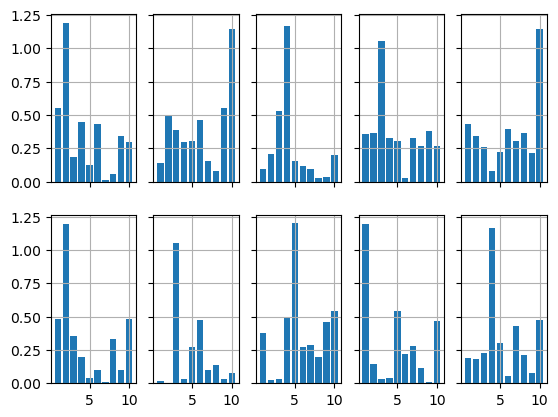

In [9]:
nrows = env.num_context // 5
create_reward_plot(env, nrows, 5)

In [10]:
# Add the algorithms to test and their hyperparameters
algo_dict = {'HyLinUCB': {'lambda': 0.1, 'gamma': 0.1},
             'LinUCBClassic': {'alpha': 0.01},
             'DisLinUCB': {'lambda': 0.1}}
delta = 0.001 # High probability guarantee

Simulating Trial 1


  0%|          | 0/2000 [00:00<?, ?it/s]

 19%|█▊        | 371/2000 [00:01<00:04, 335.54it/s]

Timestep: 400


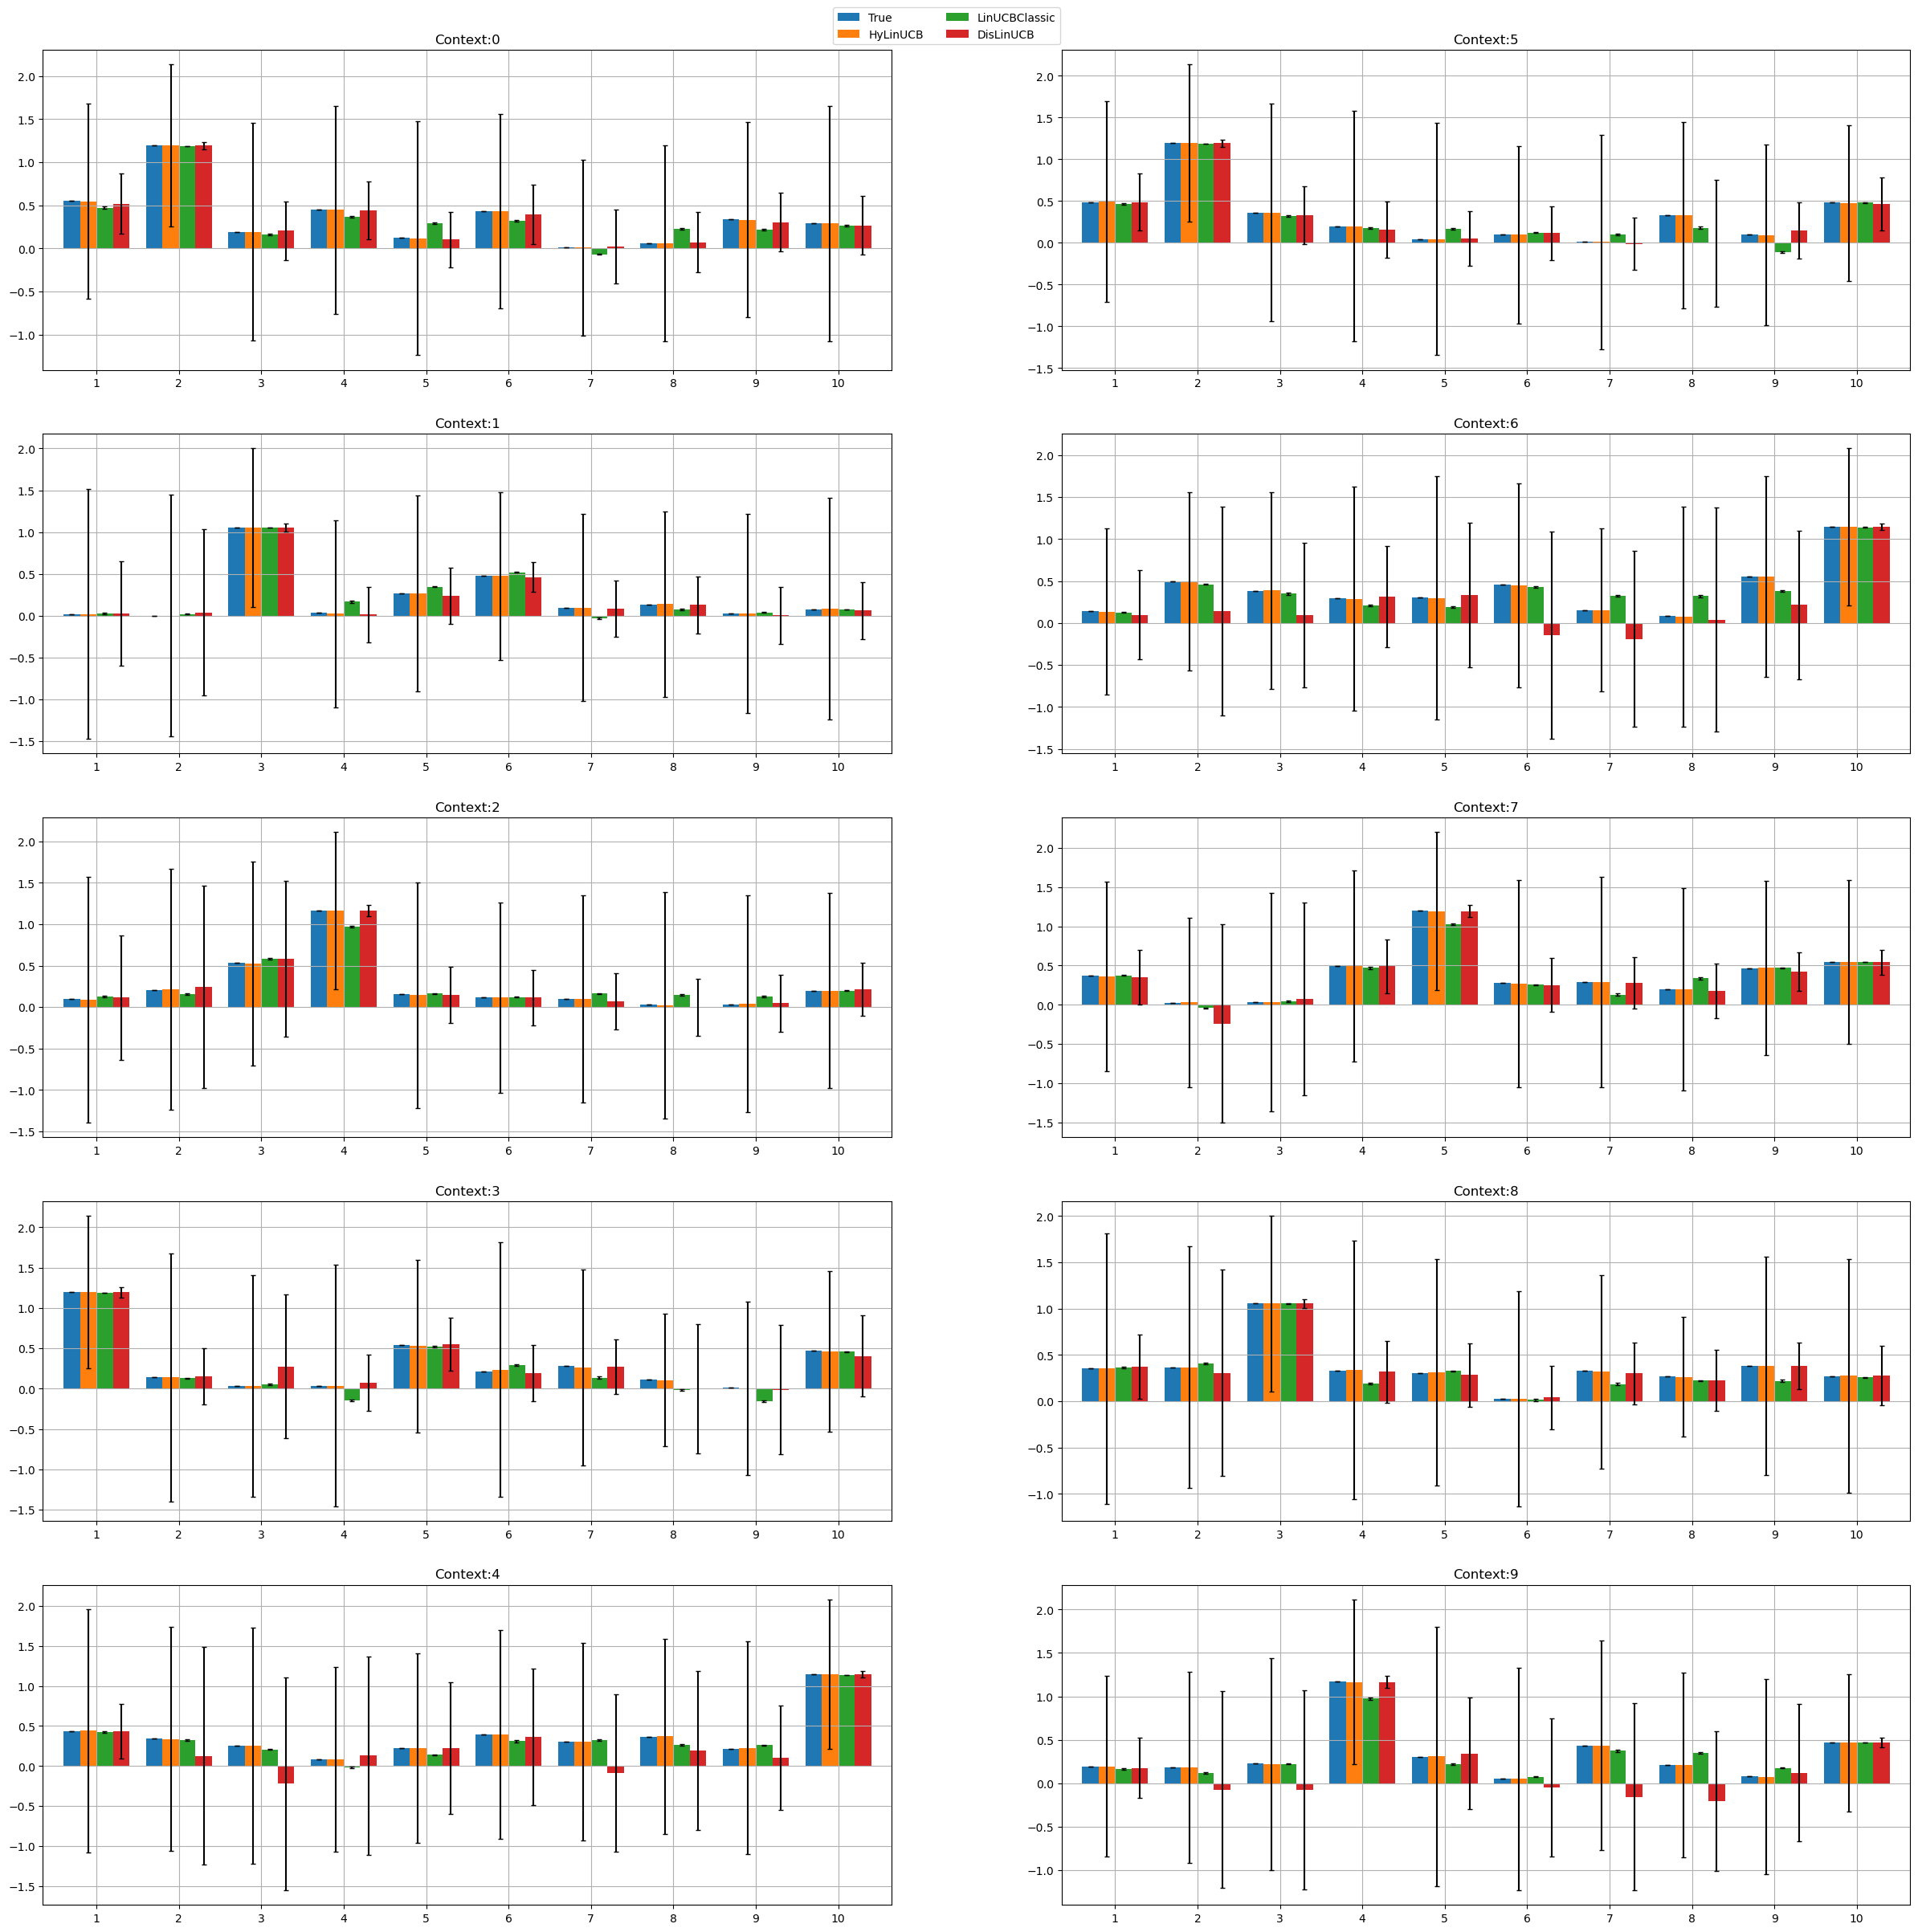

 38%|███▊      | 766/2000 [00:06<00:04, 265.72it/s]

Timestep: 800


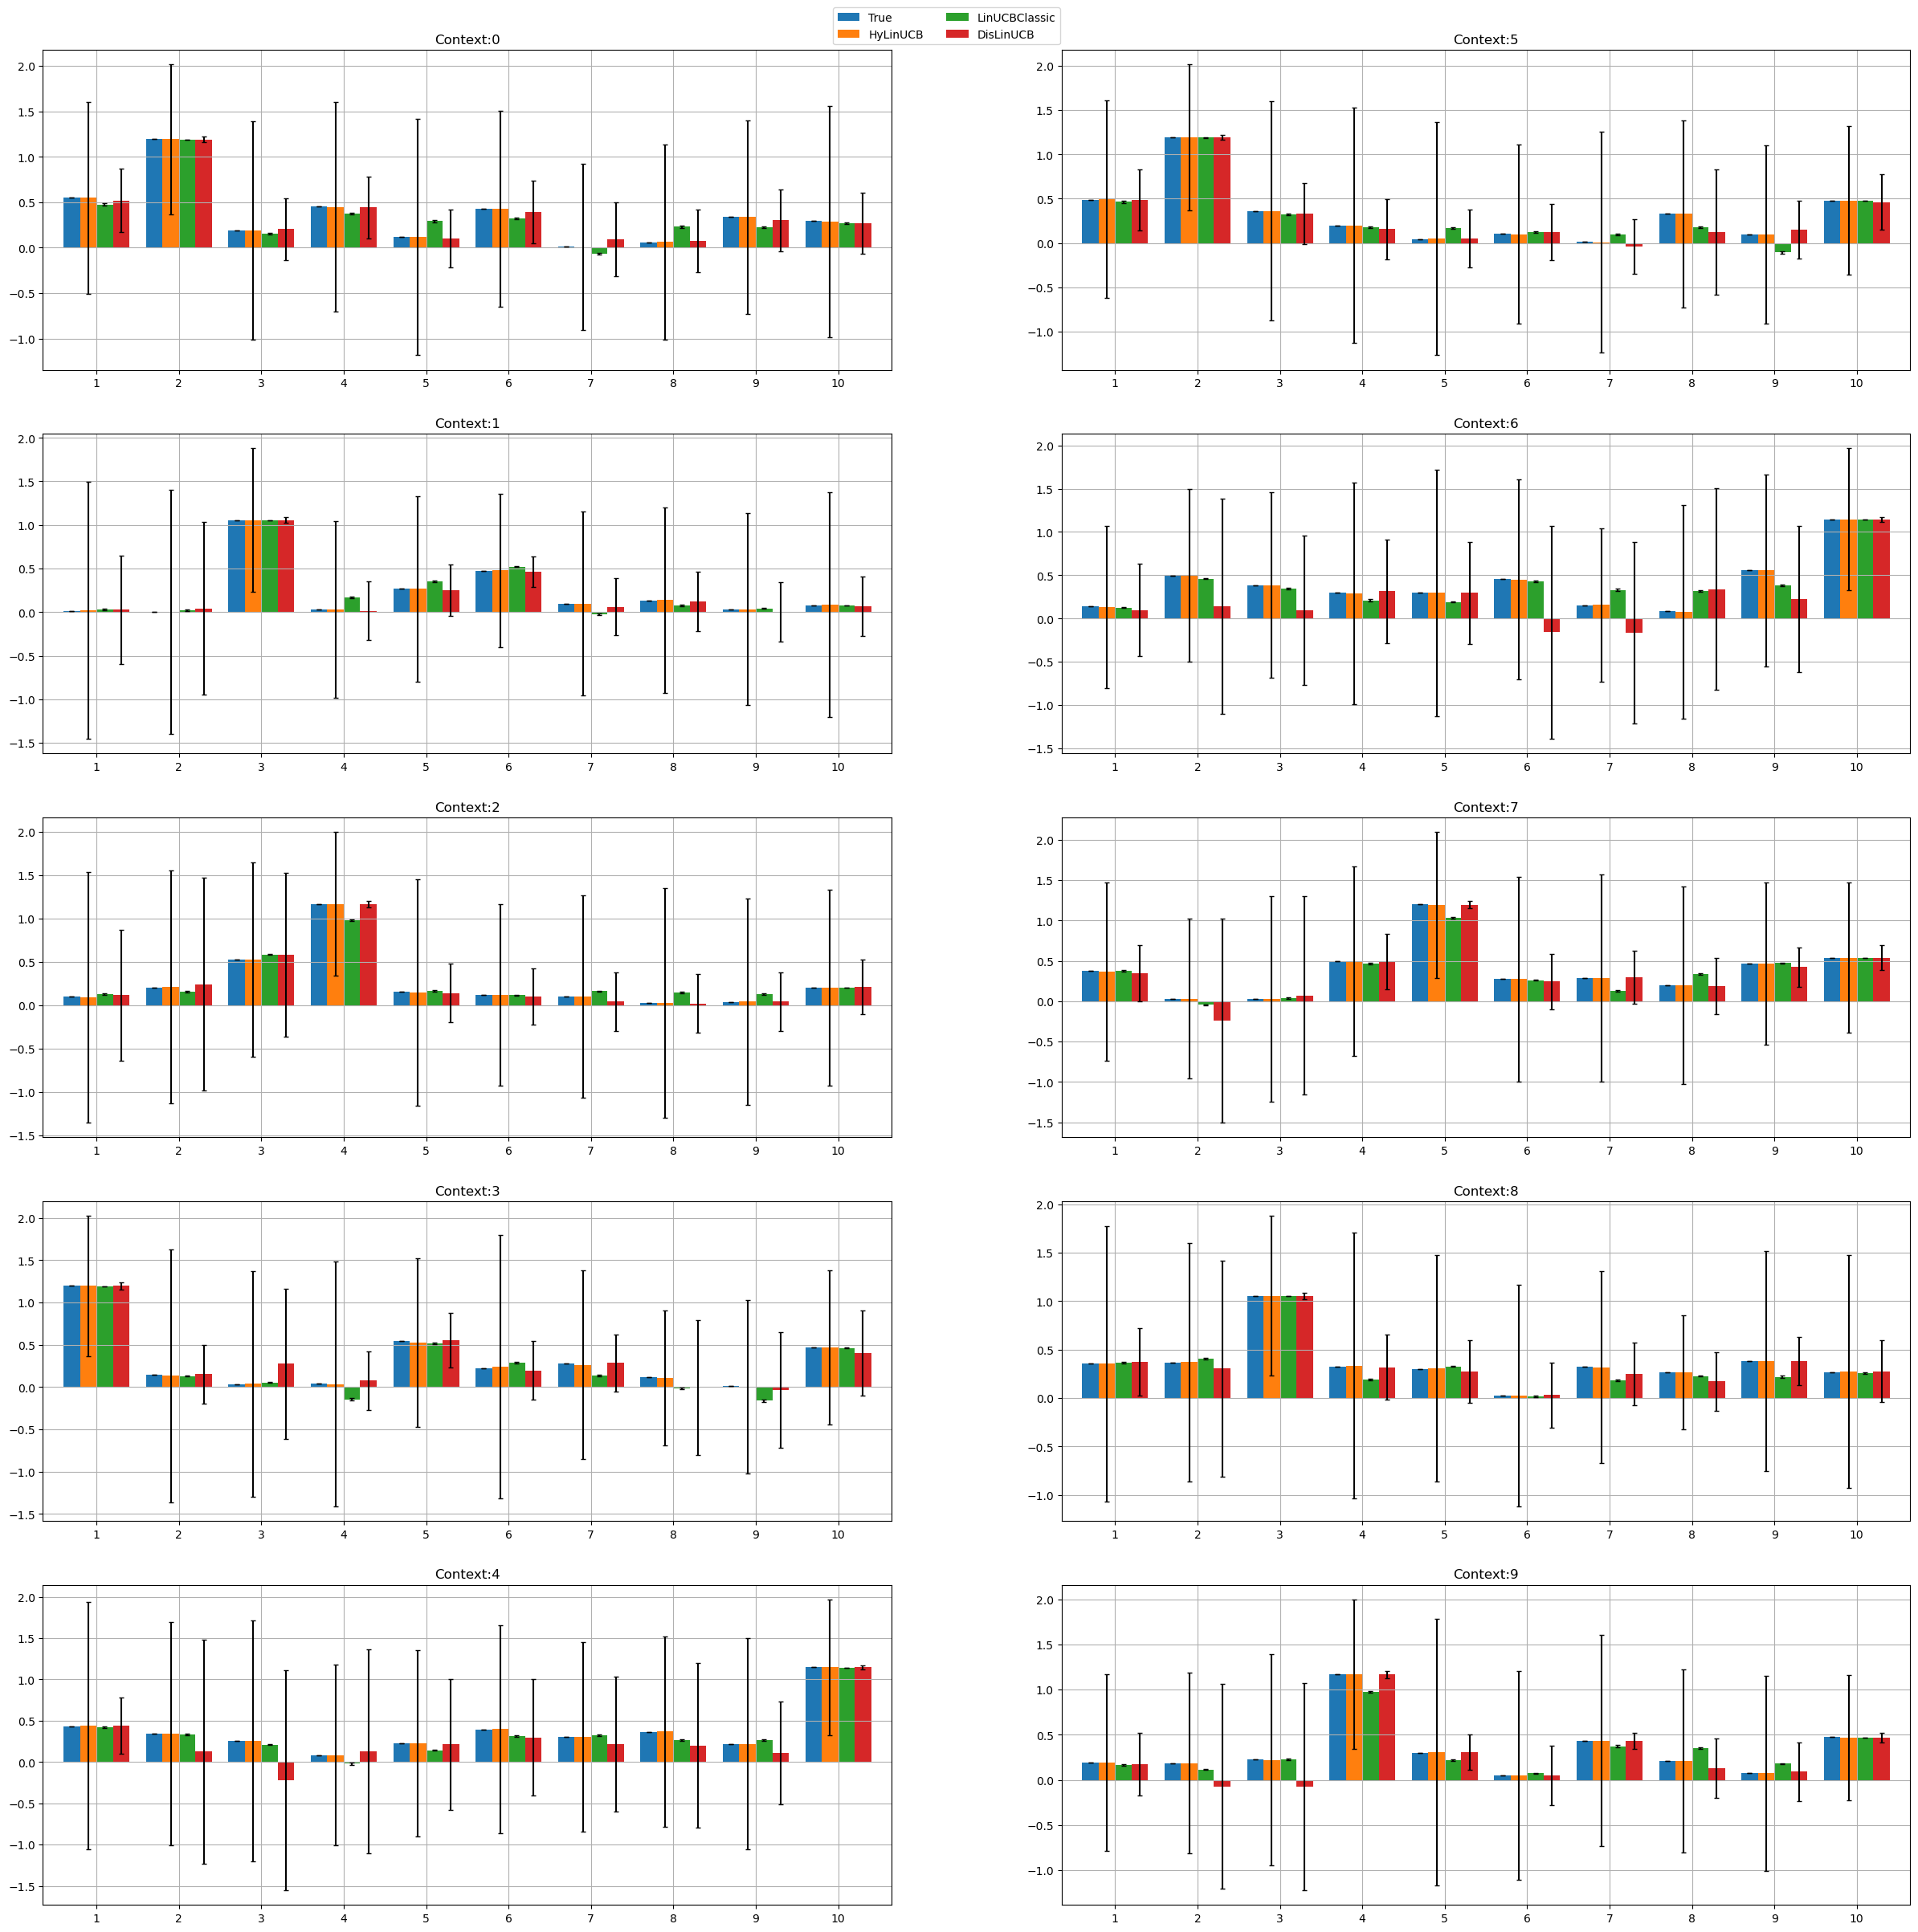

 59%|█████▉    | 1188/2000 [00:12<00:03, 269.69it/s]

Timestep: 1200


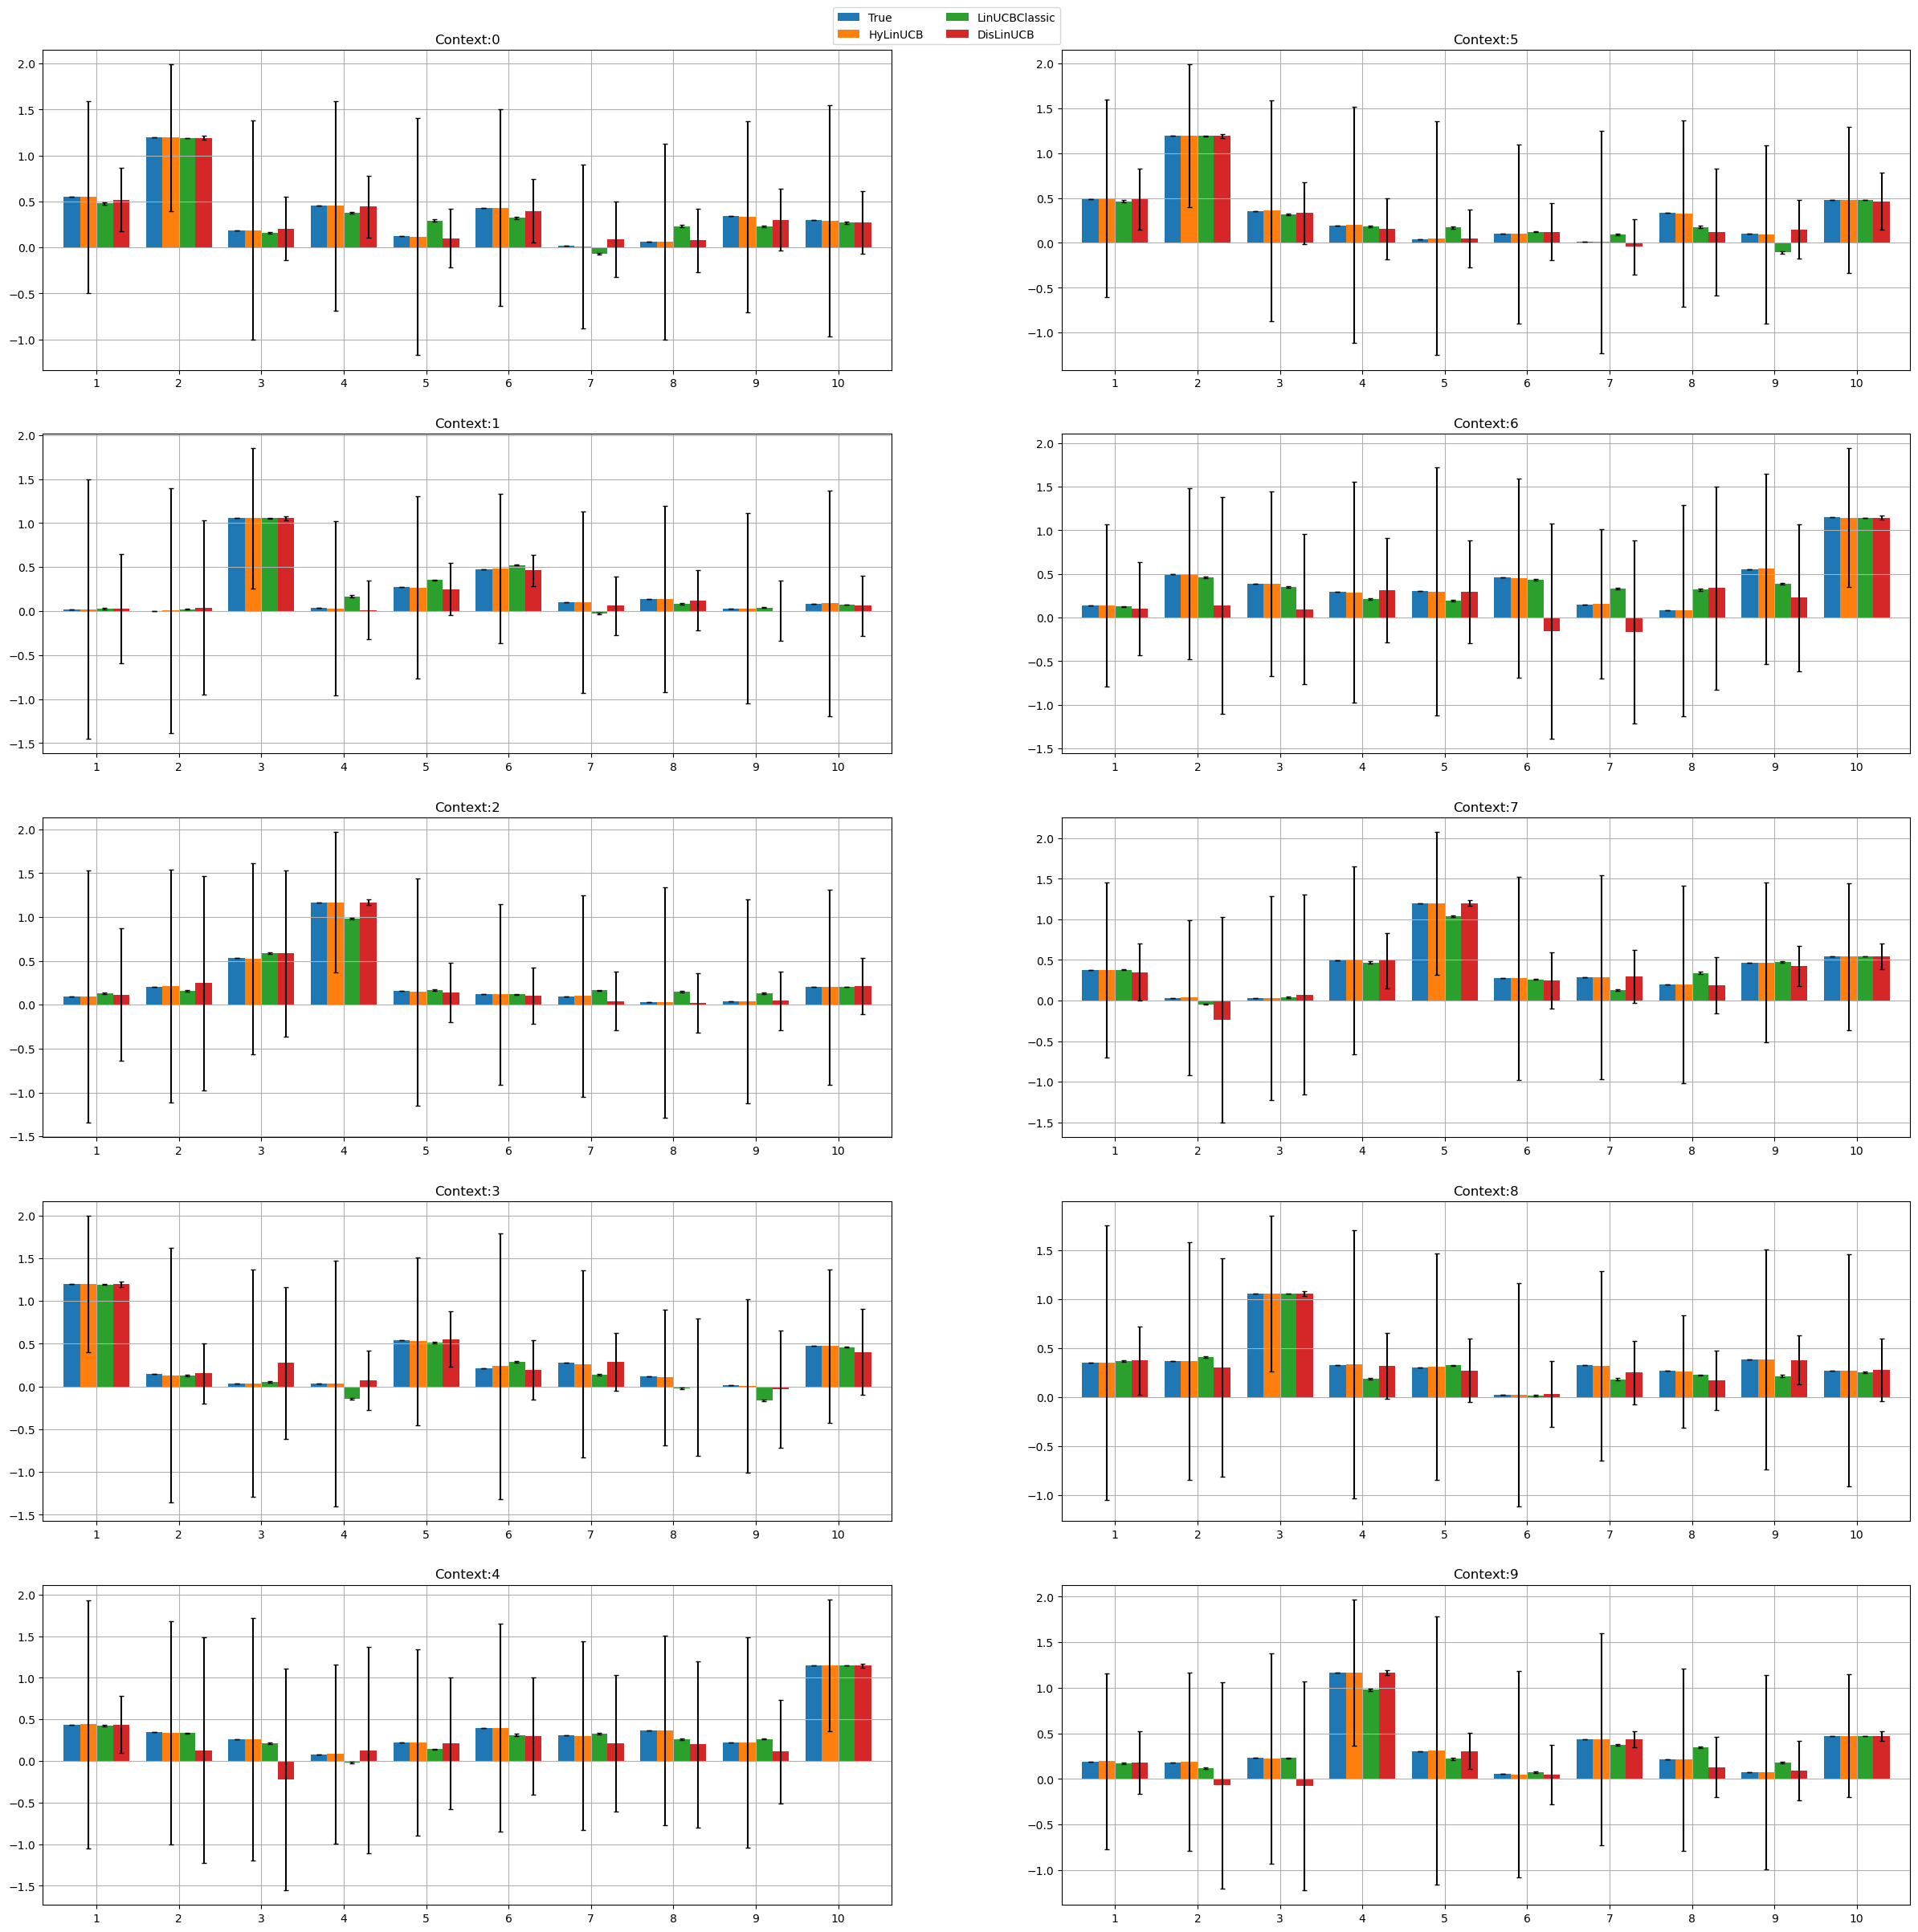

 79%|███████▉  | 1580/2000 [00:18<00:01, 249.24it/s]

Timestep: 1600


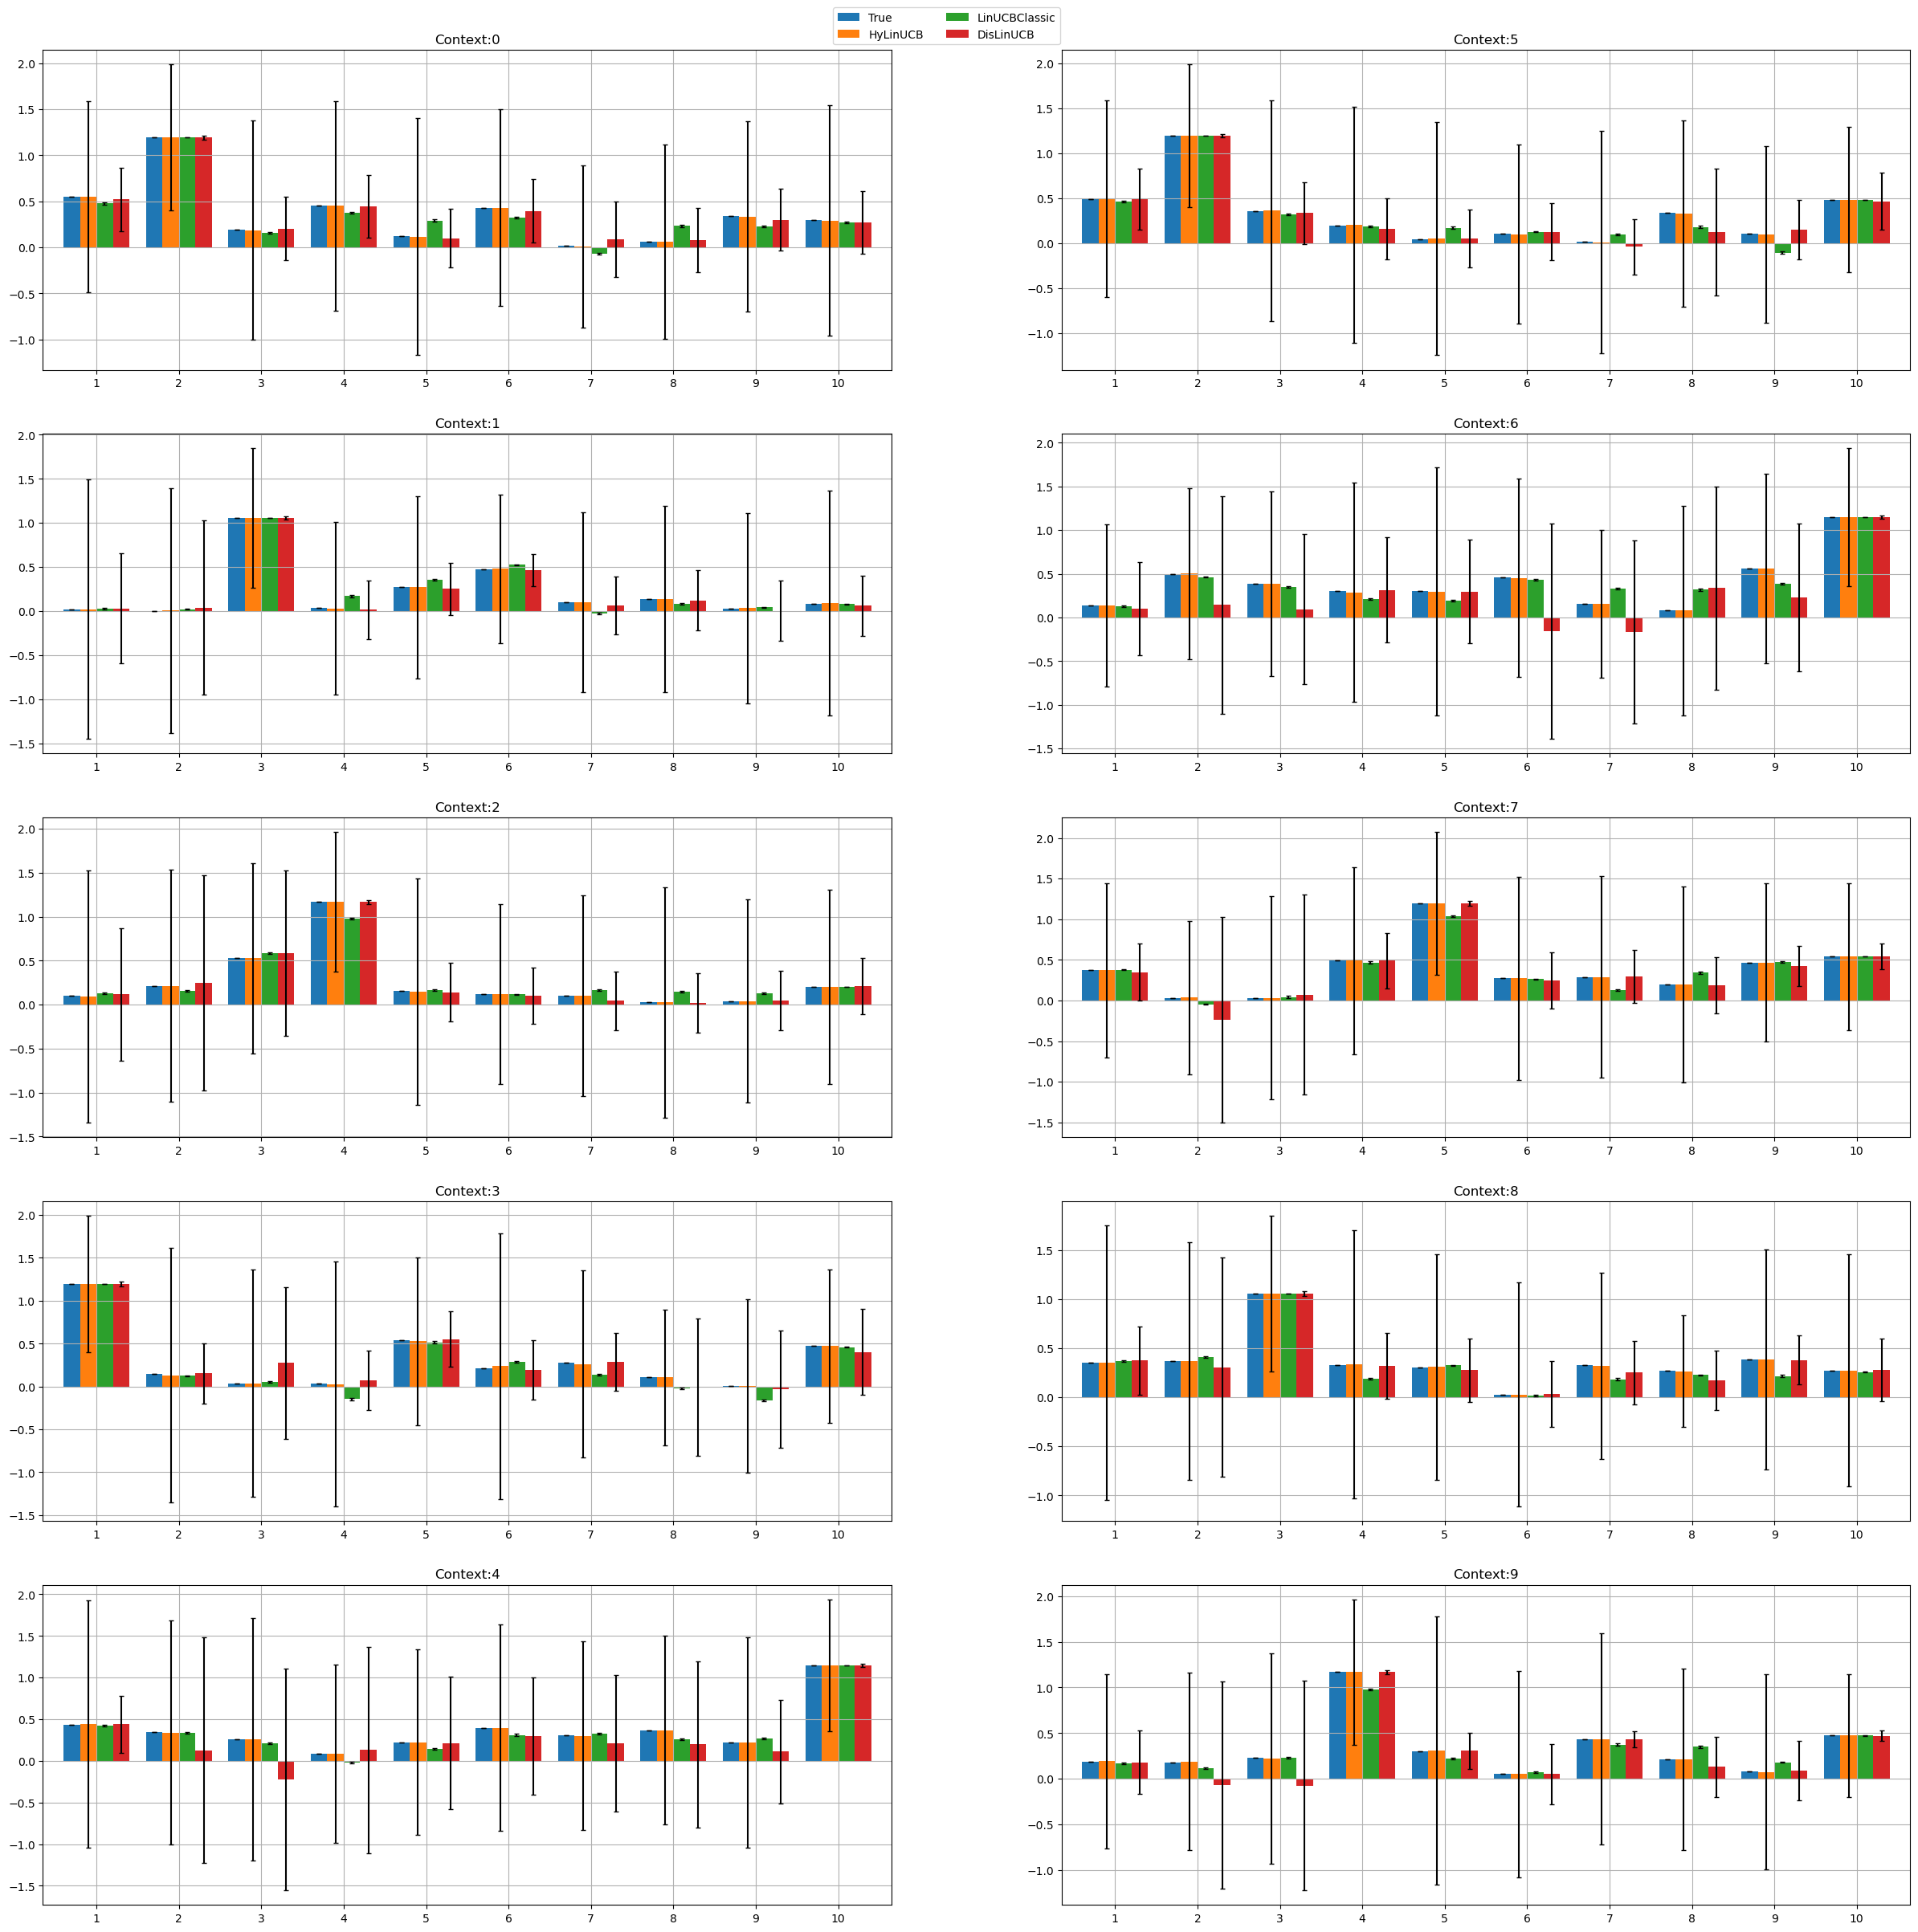

 99%|█████████▉| 1977/2000 [00:24<00:00, 243.78it/s]

Timestep: 2000


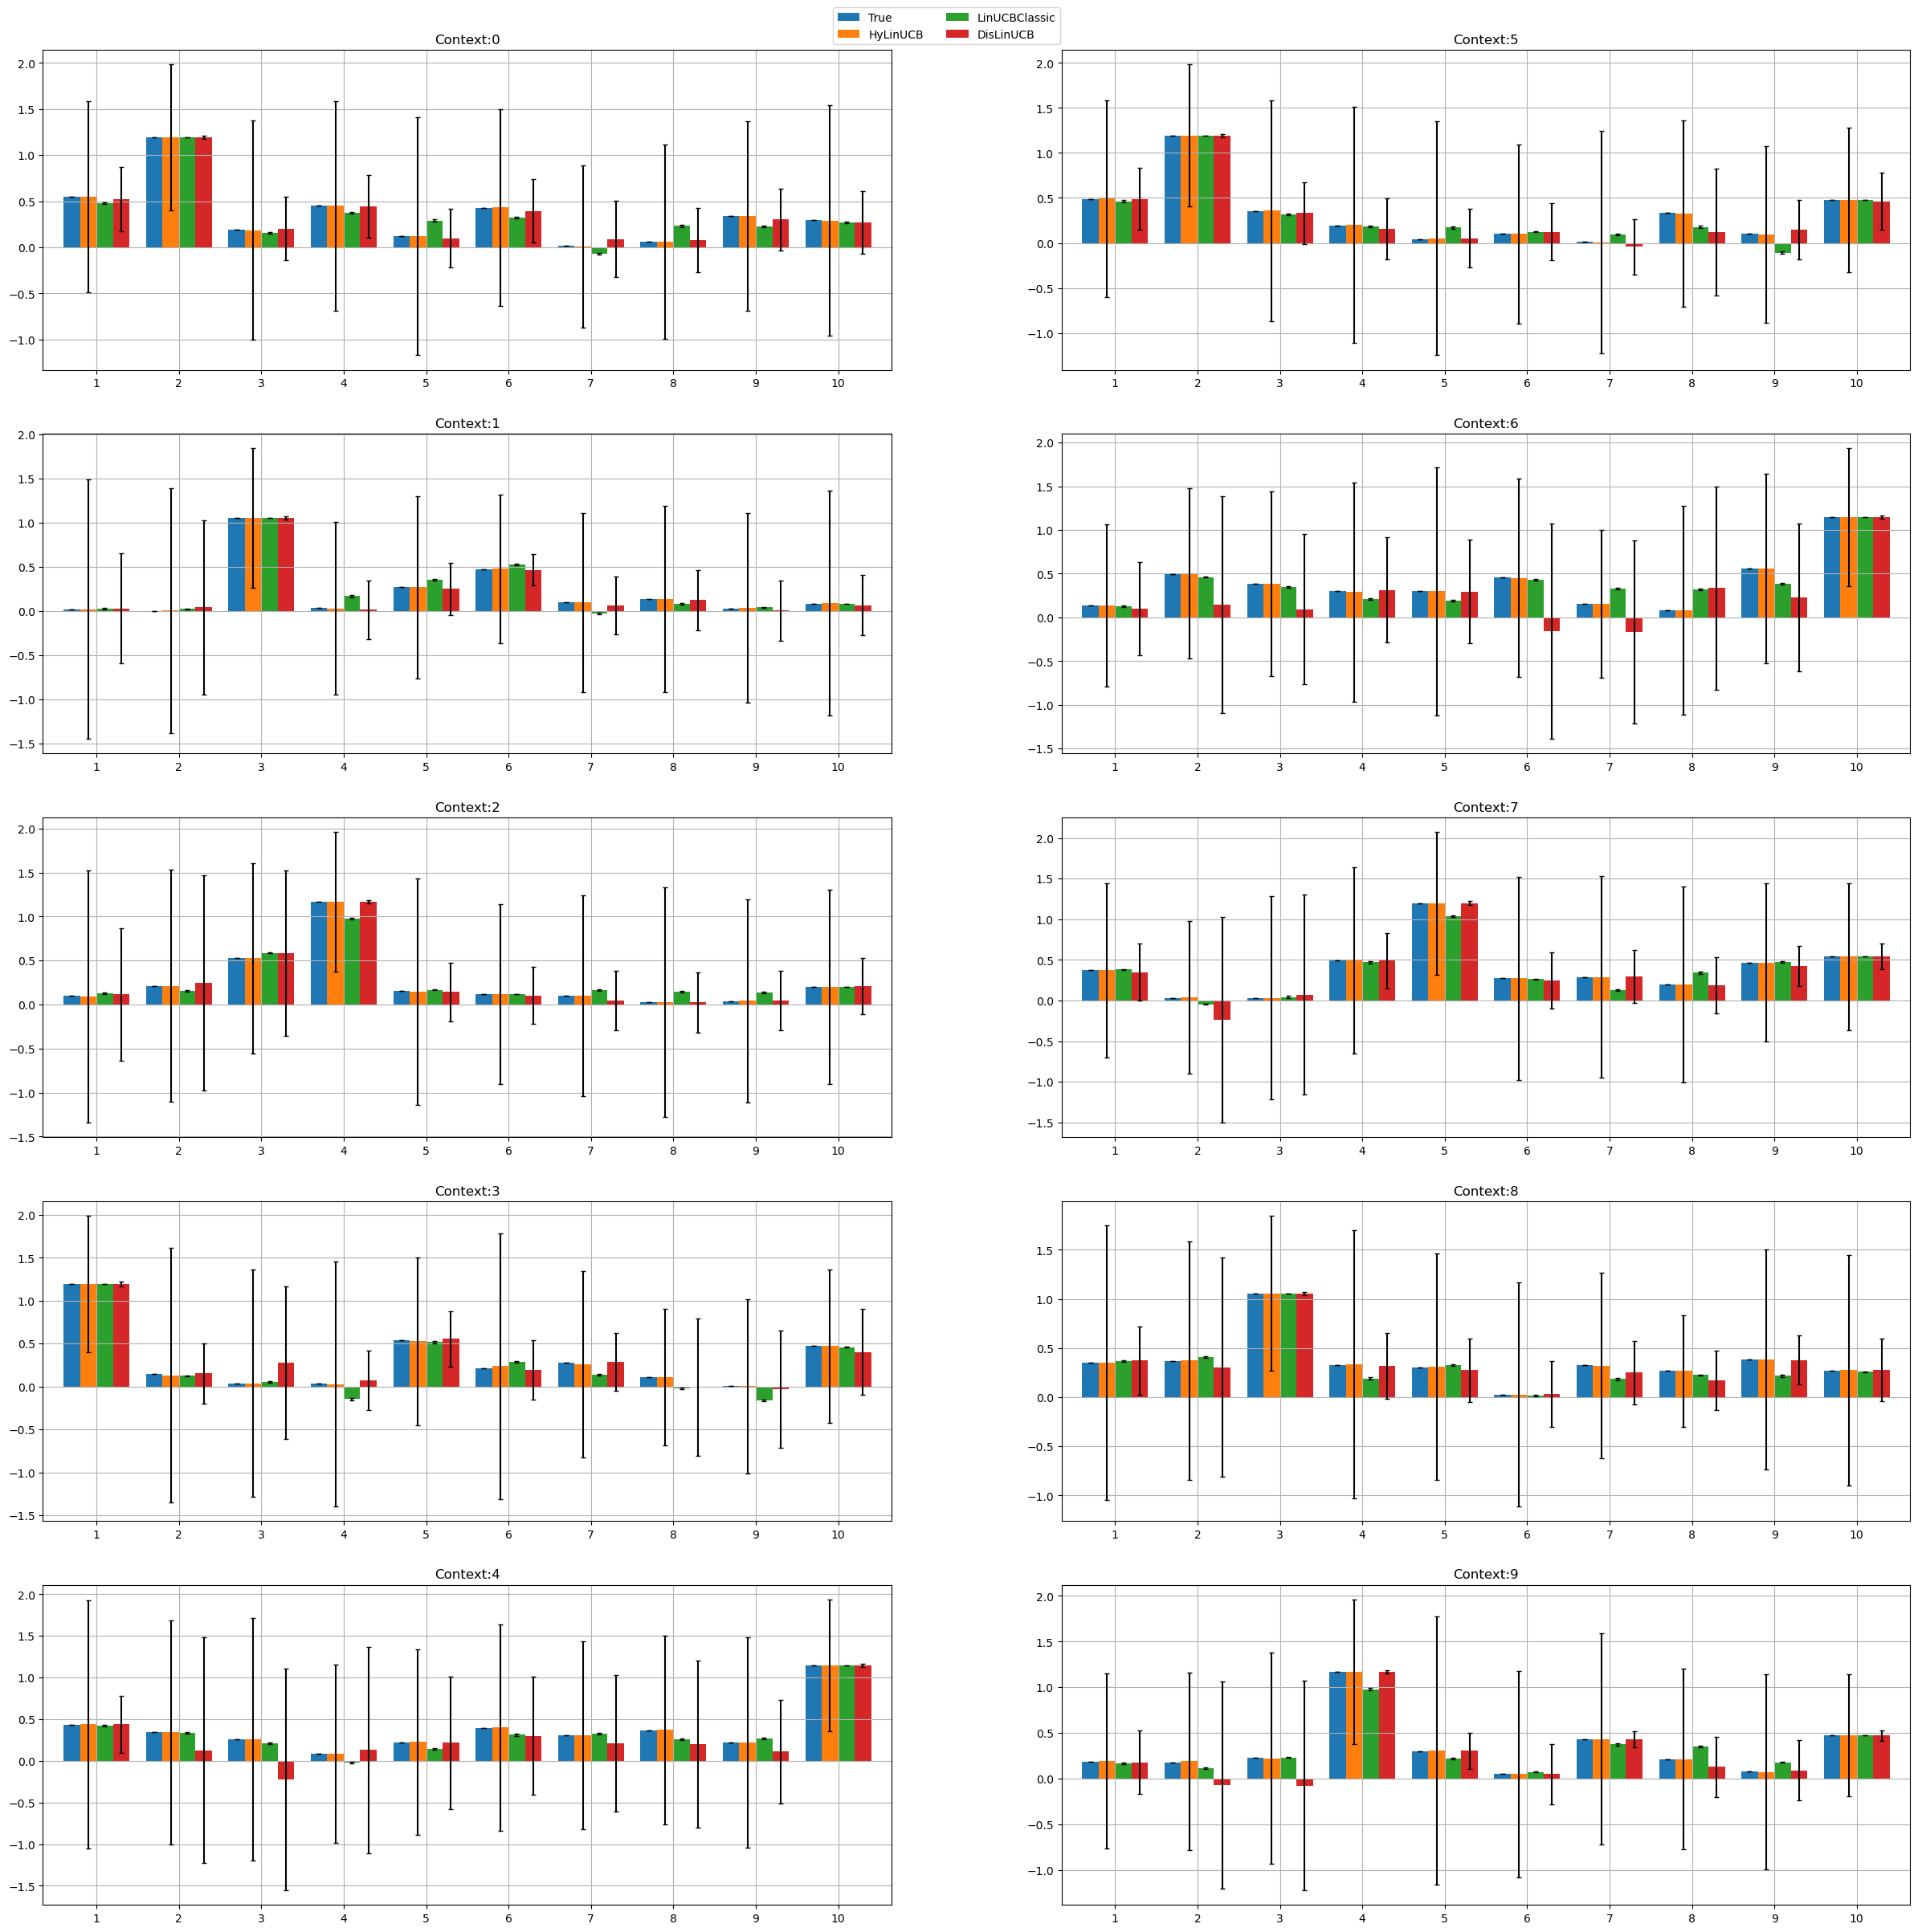

100%|██████████| 2000/2000 [00:29<00:00, 68.39it/s] 


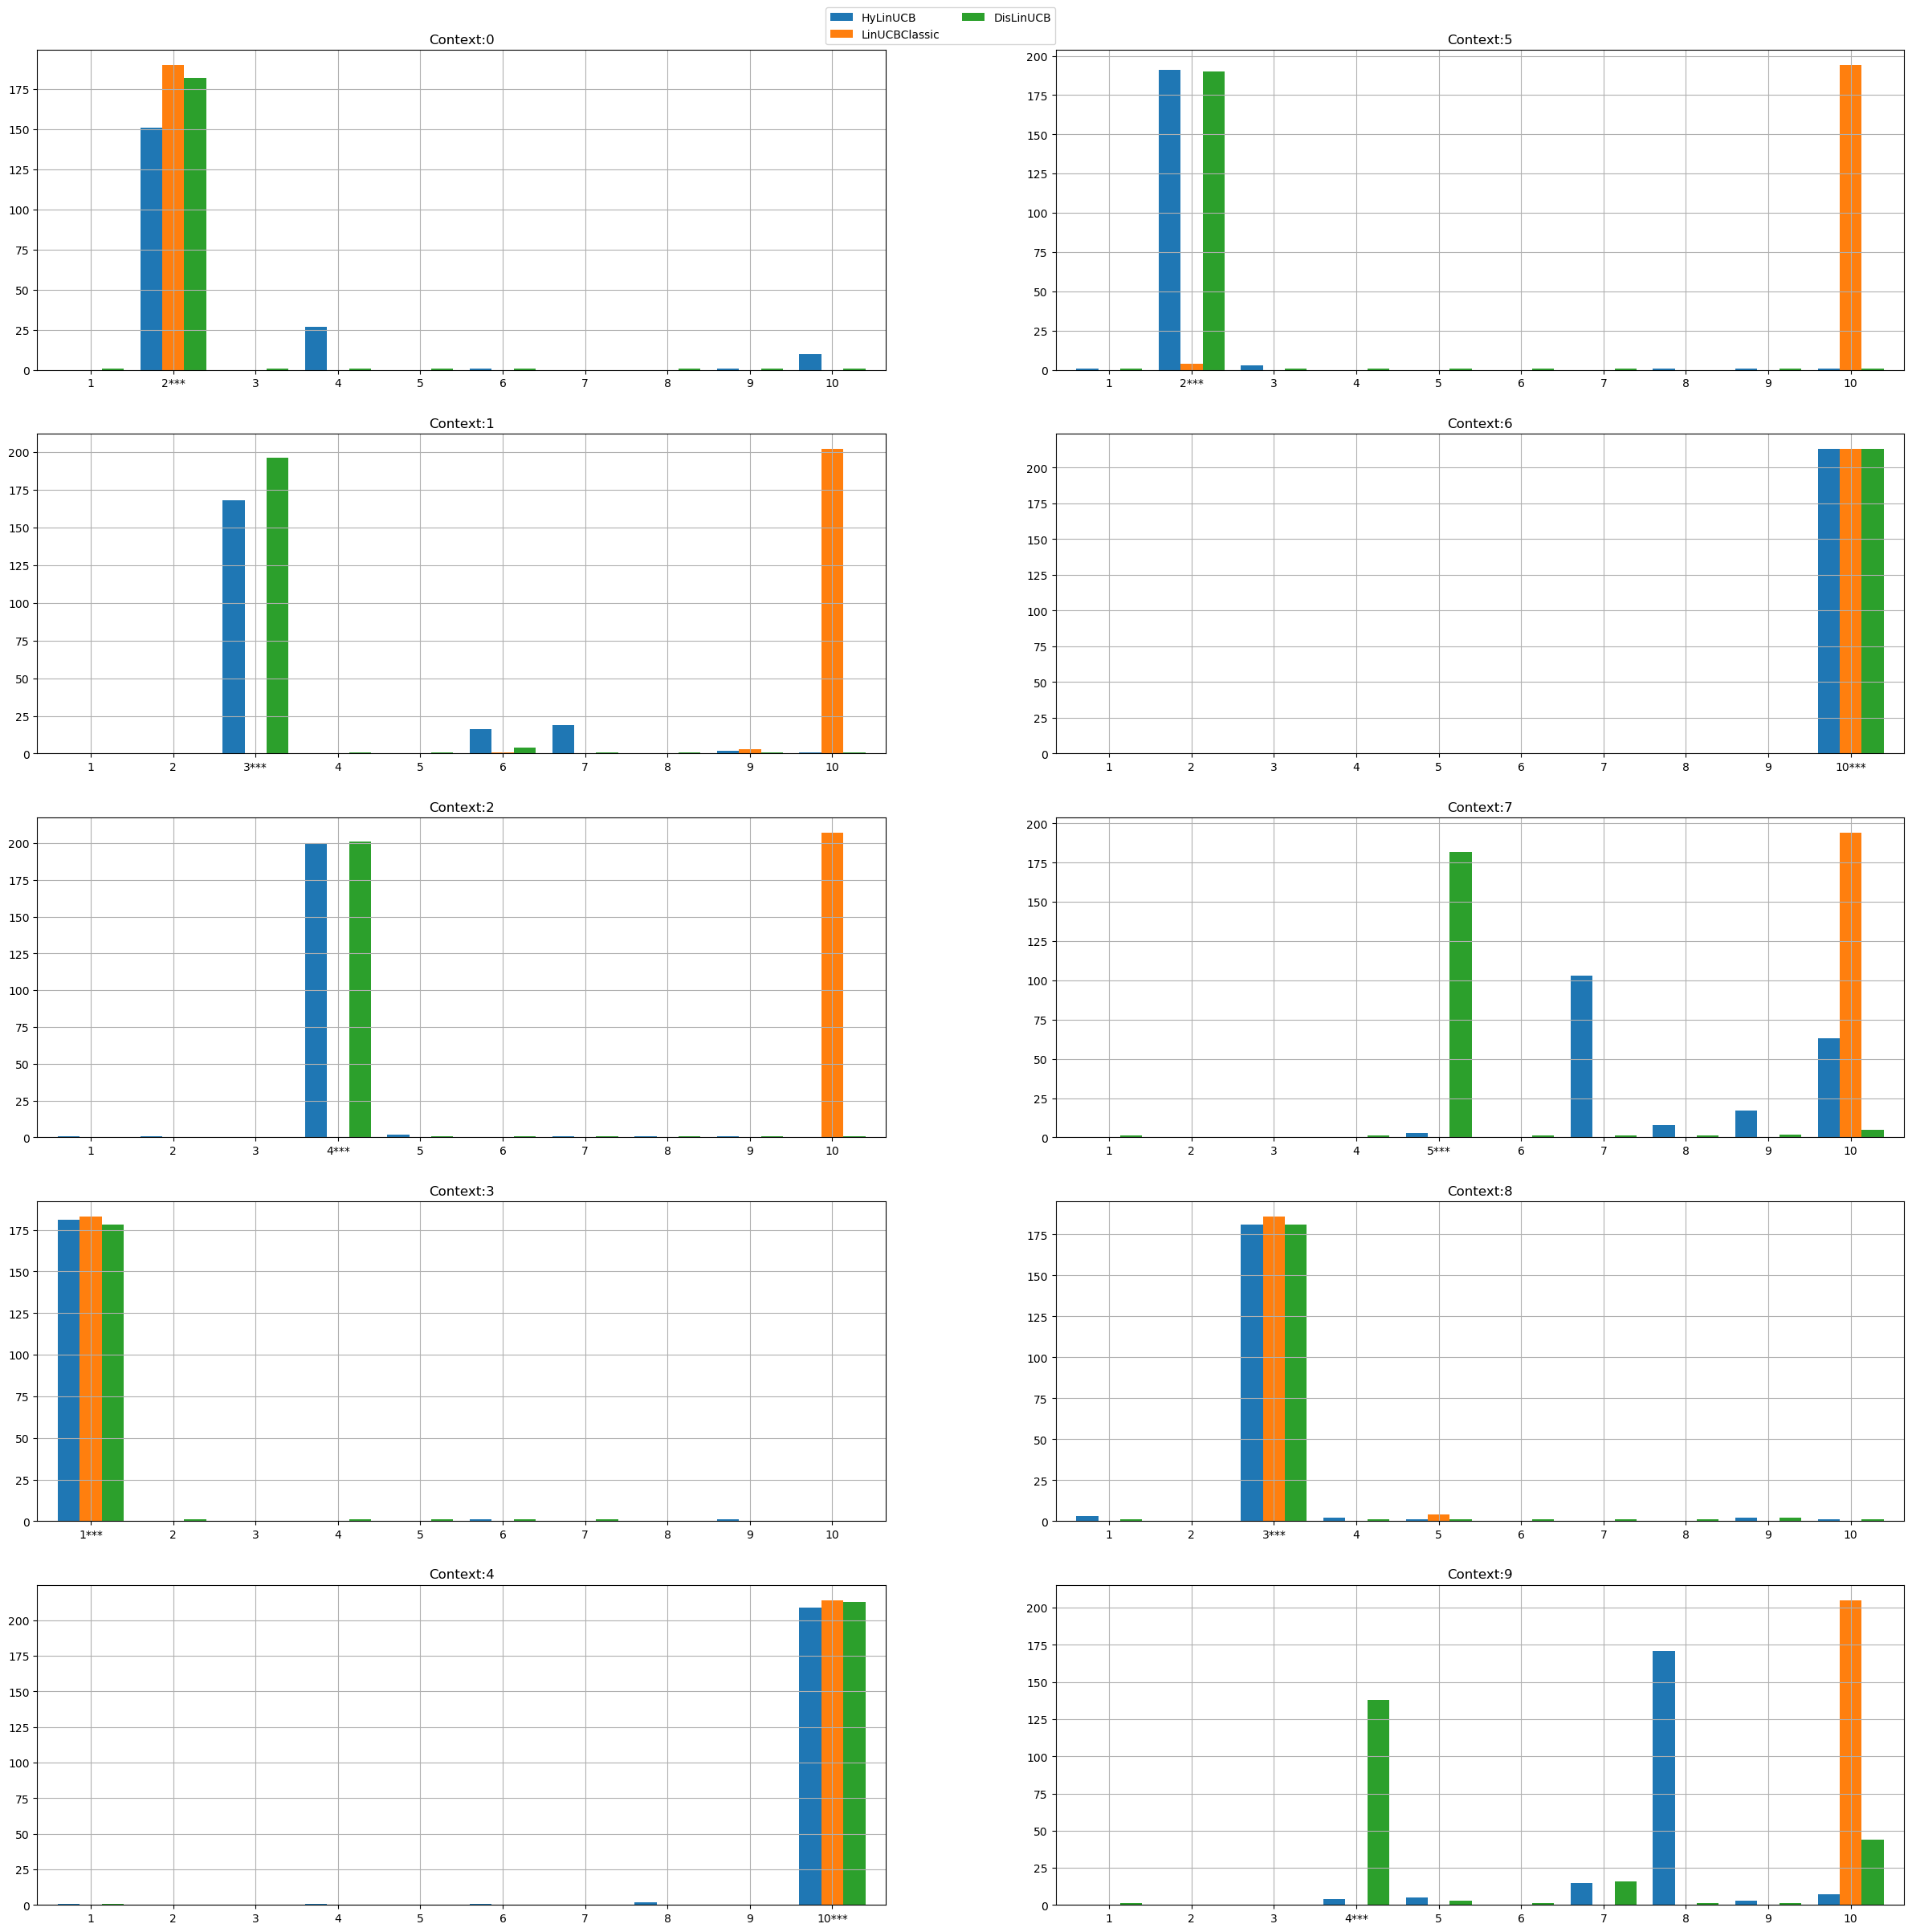

In [11]:
# Code to run multiple trials

num_trials = 1  # Number of trials
T = env.T
display = T // 5
all_rewards = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
all_regrets = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]

for i in range(num_trials):
    algo_arr = []
    for k in algo_dict.keys():
        if k == 'HyLinUCB':
            lmbda = algo_dict[k]['lambda']
            gamma = algo_dict[k]['gamma']
            algo_arr.append(HyLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda, gamma))
        elif k == 'DisLinUCB':
            lmbda = algo_dict[k]['lambda']
            algo_arr.append(DisLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda))
        elif k == 'LinUCBClassic':
            alpha = algo_dict[k]['alpha']
            algo_arr.append(LinUCBClassic(env.get_first_action_set(), env.M, env.N, env.S1, env.S2, alpha))
        elif k == 'HyLinUCBv2':
            lmbda = algo_dict[k]['lambda']
            gamma = algo_dict[k]['gamma']
            algo_arr.append(HyLinUCBv2(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, lmbda, gamma))
    print('Simulating Trial', i+1)
    ls = simulate(env, algo_arr, T, display=display)
    env.reset()
    for j in range(len(algo_arr)):
        all_rewards[j][i] += np.array(algo_arr[j].rewards)
        all_regrets[j][i] += np.array(algo_arr[j].regrets)

In [12]:
# Store results

result_dict = {}
for i, algo in enumerate(algo_dict.keys()):
    mean_reward = np.mean(all_rewards[i], axis=0)
    std_reward = np.std(all_rewards[i], axis=0)
    mean_regret = np.mean(all_regrets[i], axis=0)
    std_regret = np.std(all_regrets[i], axis=0)
    rewards = np.cumsum(mean_reward)
    regrets = np.cumsum(mean_regret)
    time_avg_rewards = rewards / np.arange(1, T+1)
    time_avg_regrets = regrets / np.arange(1, T+1)
    results = {'mean_reward': rewards, 'mean_regret': regrets, 'std_reward': std_reward,\
            'std_regret': std_regret,\
            'time_avg_reward': time_avg_rewards, 'time_avg_regret': time_avg_regrets}
    result_dict[algo] = results

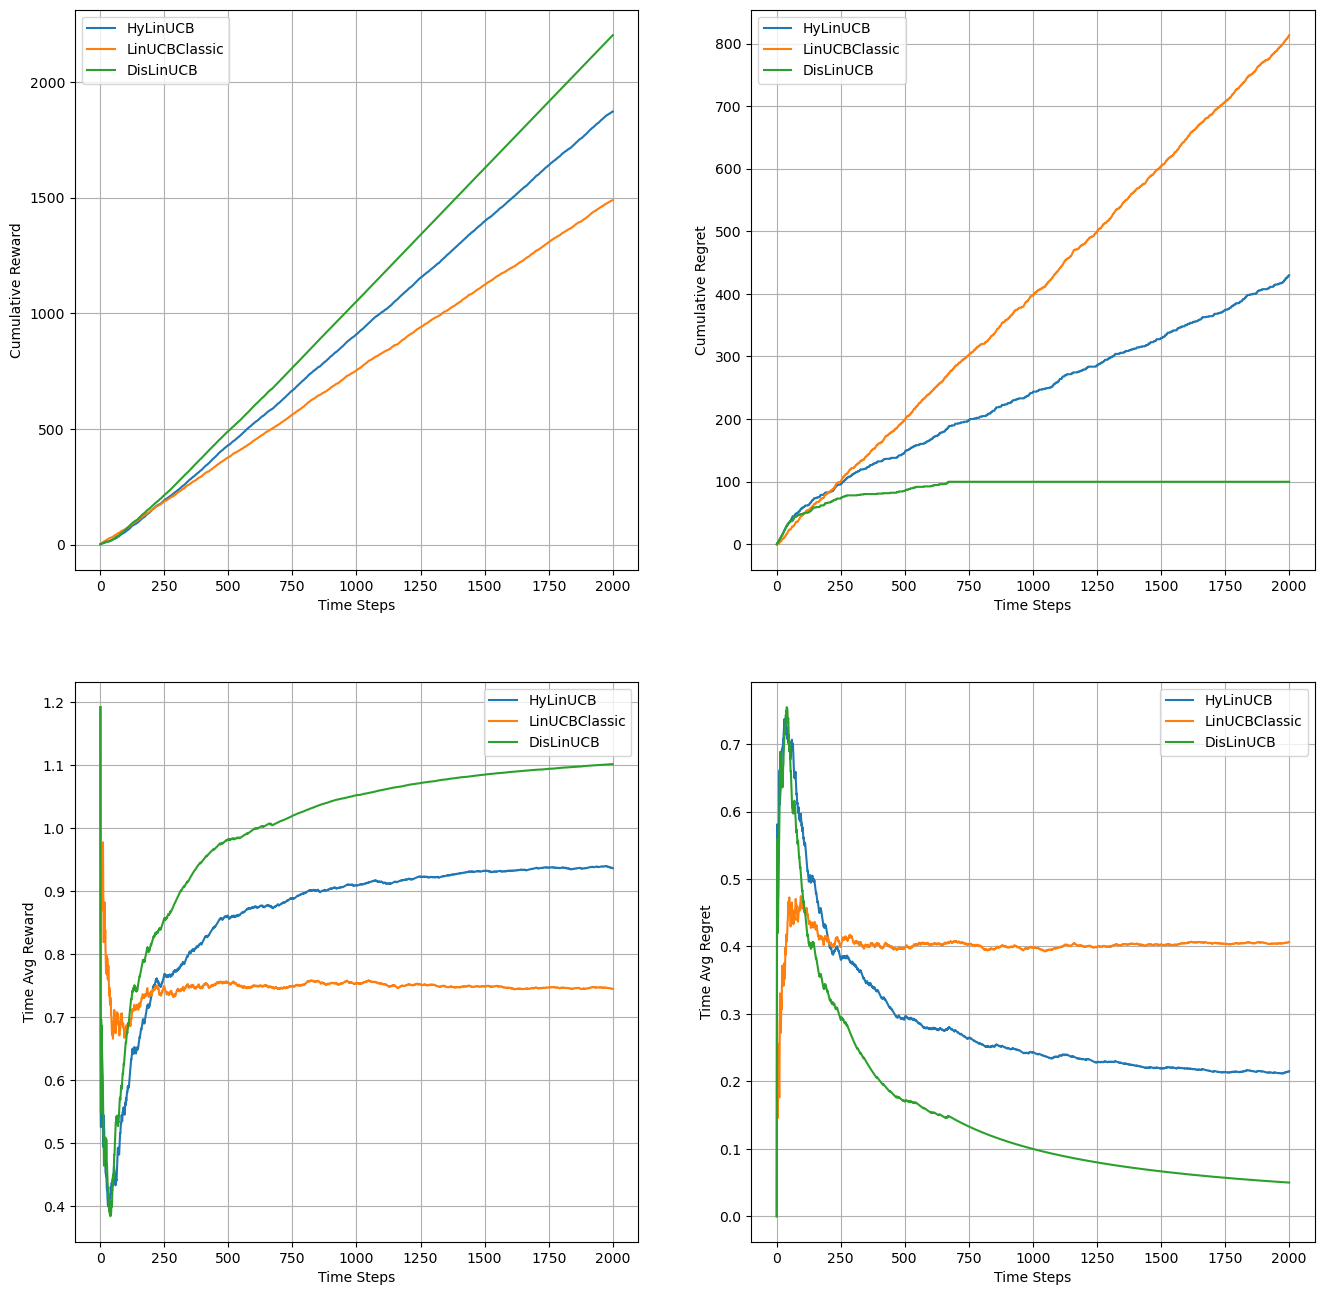

In [13]:
plot_regret(result_dict, env.T)

In [14]:
print(algo_arr)

[<algorithms.HyLinUCB.HyLinUCB object at 0x0000021497E9A250>, <algorithms.LinUCB_Classic.LinUCBClassic object at 0x0000021497E1E710>, <algorithms.DisLinUCB.DisLinUCB object at 0x0000021497E099D0>]


In [15]:
algo_arr[0].theta_hat

array([ 0.1488929 ,  0.50448447,  0.08339532, -0.58797776,  0.08526883,
        0.60129025,  0.00421356, -0.0888452 ])

In [16]:
env.parameters['theta']

array([ 0.15309976,  0.50155189,  0.07150576, -0.58630807,  0.07899505,
        0.60189521,  0.00385294, -0.08719536])

In [17]:
len(ls)

10

In [18]:
print(ls[0]['LinUCBClassic'][-10:])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


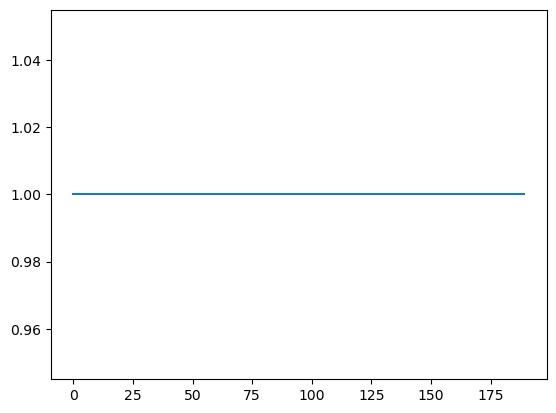

In [19]:
plt.plot(np.arange(len(ls[0]['LinUCBClassic'])), ls[0]['LinUCBClassic'])
plt.show()

In [20]:
a8 = env.arms[0][7]
a10 = env.arms[0][9]

mu8 = algo_arr[0].get_reward_estimate(7, a8)
mu10 = algo_arr[0].get_reward_estimate(7, a10)

print(mu8, '\n', mu10)

1.1147400704720014 
 1.6126869417096055
